In [12]:
!pip install -U langchain-community

   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   --------------------------------- ------ 2.1/2.5 MB 11.7 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.49
    Uninstalling langchain-core-0.3.49:
      Successfully uninstalled langchain-core-0.3.49
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.7
    Uninstalling langchain-text-splitters-0.3.7:
      Successfully uninstalled langchain-text-splitters-0.3.7
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.22
    Uninstalling langchain-0.3.22:
      Successfully uninstalled langchain-0.3.22
  Attempting uninstall: langchain-community
    Found 

In [1]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from openai import OpenAI
from getpass import getpass

from langchain.document_loaders import JSONLoader
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings


from langchain.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

from langchain_cohere import CohereRerank
from langchain.retrievers import ContextualCompressionRetriever
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI


In [ ]:
MY_API_KEY = getpass("OpenAI API Key:")

In [ ]:
client = OpenAI(api_key=MY_API_KEY)

In [5]:
file_path = "data/output.json"

In [6]:
# JSON 데이터 로드 함수
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

### **CHUNKING**

In [7]:
# JSON 데이터 로드 및 청킹 함수 정의
def load_and_summarize_json(file_path):
    try:
        data = load_json_data(file_path)
        print(f"로드된 JSON 데이터 개수: {len(data)}개")

        # 청킹: 주요 정보 추출
        summary = []
        for item in data:
            summary.append({
                'ID': item.get('id'),
                '위치': f"{item.get('자치구')} {item.get('행정동')}",
                '제목': item.get('title'),
                '업종': item.get('업종'),
                '보증금': f"{item.get('보증금액')}만원",
                '월세': f"{item.get('월세금액')}만원",
                '권리금': f"{item.get('권리금액')}만원" if item.get('권리금액', 0) > 0 else '없음',
                '면적(㎡)': item.get('면적'),
                '층수': item.get('층수'),
                '설명': item.get('description')
            })

        return summary

    except FileNotFoundError:
        print(f"파일을 찾을 수 없습니다: {file_path}")
    except Exception as e:
        print(f"오류 발생: {e}")

# 실행 및 결과 출력
summarized_data = load_and_summarize_json(file_path)

if summarized_data:
    # 첫 5개 항목 출력
    for item in summarized_data[5:11]:
        print(item)


로드된 JSON 데이터 개수: 134411개
{'ID': 100291, '위치': '마포구 합정동', '제목': '복층합정카페라인인근무권리상가', '업종': '없음', '보증금': '3000만원', '월세': '250만원', '권리금': '없음', '면적(㎡)': 158.7, '층수': '3층', '설명': '층총층344금액보증금3000월세250권리금무역세권거리합정역5번출구3분평수총24평24평복층입주가능시기협의후합정카페거리에서홍대로올라가는길목에위치하여입지조건굉장히좋습메인길34층복층으로구성되어총평수는48평정도나옵일반사무실로도사용가능건물주께서내부수리완료하시어깔끔한상태로입주가능하므로복층사무실찾으시는분께서는홍대합정상수망원최다보유친절책임중개홍대대박은항상정직한정보와믿을수있는중개서비스를통하여최대한신속하게원하시는가격의물건을찾아드립자신있습홍대대박24시간연중무휴영업주차대수5독립공간7'}
{'ID': 100444, '위치': '송파구 잠실동', '제목': '잠실새내역5분거리의위치좋은시설깔끔한점포', '업종': '한식고기집', '보증금': '8000만원', '월세': '400만원', '권리금': '없음', '면적(㎡)': 198.3, '층수': '1층', '설명': '잠실새내역5분거리의위치좋은시설깔끔한점포복층구조로내부계단과화장실있음1,2층모두닥트시설되어있으며고기집은손볼대가없이그대로영업해도됩주차대수5'}
{'ID': 100474, '위치': '관악구 신림동', '제목': '대로변점포급매', '업종': '가구가전', '보증금': '2000만원', '월세': '120만원', '권리금': '1000만원', '면적(㎡)': 26.4, '층수': '1층', '설명': '대로변점포급매1층약8평보2000120시권1000대로변유동인구많음횡단보도앞의류통신등타업종가능'}
{'ID': 100506, '위치': '송파구 잠실동', '제목': '신천먹자골목유동인구많은가지상권', '업종': '한식고기집', '보증금': '7000만원', '월세': '320만원', '권리금': '4000만원', '면적(㎡)':

In [8]:
# JSON 데이터에서 추출된 summary 데이터를 ID별로 청킹
formatted_texts = [
    f"ID: {item['ID']}\n제목: {item['제목']}\n위치: {item['위치']}\n업종: {item['업종']}\n"
    f"보증금: {item['보증금']}\n월세: {item['월세']}\n권리금: {item['권리금']}\n"
    f"면적(㎡): {item['면적(㎡)']}\n층수: {item['층수']}\n설명: {item['설명']}"
    for item in summarized_data
]

print(f"데이터 개수: {len(formatted_texts)}개")

데이터 개수: 134411개


최소 길이: 91
최대 길이: 1502
평균 길이: 285.0882814650587



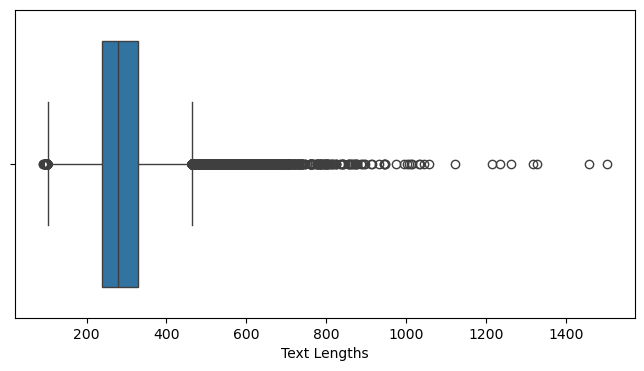

In [9]:
# 텍스트 길이가 들어간 리스트
text_lengths = [len(text) for text in formatted_texts]

print(f"최소 길이: {min(text_lengths)}")
print(f"최대 길이: {max(text_lengths)}")
print(f"평균 길이: {sum(text_lengths) / len(text_lengths)}")
print()

# 텍스트 길이 분포 확인
plt.figure(figsize=(8, 4))
sns.boxplot(x=text_lengths)
plt.xlabel('Text Lengths')
plt.show()

In [10]:
# "id"를 기준으로 청크 분류하는 스플리터 정의
json_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 300,    # 가장 분포가 많은 300으로 청크 사이즈 설정
    chunk_overlap = 0,   # 문맥이 필요하지 않으므로 중복값 0으로 설정
    separators = ["id"]  # 각 줄을 id를 기준으로 분리
)

# 텍스트를 청크로 분할
my_chunks = []
for text in formatted_texts:
    chunks = json_splitter.split_text(text)
    my_chunks.extend(chunks)

# 청크 개수 확인
print(f"데이터 개수: {len(formatted_texts)}개")
print(f"변환된 텍스트 청크 개수: {len(my_chunks)}개")
print()
print(f"청크 구조 : \n{formatted_texts[0]}")

데이터 개수: 134411개
변환된 텍스트 청크 개수: 134411개

청크 구조 : 
ID: 100073
제목: 유동인구많은커피숖상가
위치: 구로구 구로동
업종: 카페커피
보증금: 2000만원
월세: 140만원
권리금: 3000만원
면적(㎡): 57.96
층수: 지하1층
설명: 전용면적175평계약면적347평관리비대략평당4500원전기,수도요금별도계절별상이함권리금커피머신등현재상태그대로인수시3000만원커피머신제외상가인수시1000만원주차대수319


### **EMBEDDING**

In [ ]:
# 임베딩 모델 정의
my_embedding = OpenAIEmbeddings(model = "text-embedding-3-small",
                                api_key = MY_API_KEY
                               )

### **DB에 저장, METADATA 포함**

#### 아래 코드 돌리면 저장하는 데에 10시간 정도 걸리니까,,, streamlit에 있는 chroma_db3로 쓰면 돼요. 그래서 주석 처리 해놓을게여

In [11]:
# from langchain.schema import Document
# from langchain_openai import OpenAIEmbeddings
# from chromadb import PersistentClient
# import os
# import re
# from tqdm import tqdm  
# import traceback  

# # OpenAI API 키 설정
# os.environ["OPENAI_API_KEY"] = MY_API_KEY  
# openai_api_key = os.getenv("OPENAI_API_KEY")

# # 임베딩 모델 초기화
# my_embedding = OpenAIEmbeddings(openai_api_key=openai_api_key)

# # 새로운 저장 폴더 설정
# persist_directory = "./chroma_db"

# # ChromaDB 클라이언트 초기화
# chroma_client = PersistentClient(path=persist_directory)

# # 컬렉션 생성 (ChromaDB 0.6.3 방식)
# collection = chroma_client.get_or_create_collection(name="my_collection")

# # 문서 변환 (데이터 파싱 개선)
# documents = []
# for chunk in tqdm(my_chunks, desc="Processing Chunks"):  # tqdm 추가
#     try:
#         data_parts = {}
        
#         # ":" 기준으로 key-value 분리, 공백 없이 붙어 있는 경우도 처리
#         matches = re.findall(r"([\w\s\(\)㎡]+):\s*([^:\n]+)", chunk)
        
#         for key, value in matches:
#             data_parts[key.strip()] = value.strip()

#         # Document 객체 생성
#         doc = Document(
#             page_content=chunk,
#             metadata={
#                 "id": data_parts.get("ID", ""),
#                 "location": data_parts.get("위치", ""),
#                 "type": data_parts.get("업종", ""),
#                 "deposit": data_parts.get("보증금", ""),
#                 "rent": data_parts.get("월세", ""),
#                 "key_money": data_parts.get("권리금", ""),
#                 "area": data_parts.get("면적(㎡)", ""),
#                 "floor": data_parts.get("층수", ""),
#                 "description": data_parts.get("설명", "")
#             }
#         )

#         documents.append(doc)

#         # ChromaDB에 데이터 추가 (Chroma 0.6.3 방식)
#         collection.add(
#             ids=[data_parts.get("ID", str(len(documents)))],  # ID 없으면 인덱스 사용
#             documents=[doc.page_content],
#             metadatas=[doc.metadata]
#         )

#     except Exception as e:
#         # 디버깅을 위한 코드
#         print(f"Error processing chunk: {chunk}")
#         print(f"Error: {e}")
#         traceback.print_exc()  # 에러 트레이스백 출력

# # 저장된 문서 개수 출력
# print(f"새 폴더에 저장된 문서 개수: {len(documents)}개")


In [ ]:
# 모든 문서의 메타데이터 출력
for doc, metadata in zip(documents, collection.get()['metadatas']):
    print(f"Document: {doc.page_content[:100]}...")  # 첫 100자만 출력
    print(f"Metadata: {metadata}")
    print("-" * 50)  # 구분선


In [ ]:
# 저장된 문서 개수 확인
print(f"총 저장된 문서 개수: {collection.count()}개")

# 저장된 문서 일부 가져오기
retrieved_docs = collection.get()

# 첫 번째 문서 내용 확인
print(f"첫 번째 문서 ID: {retrieved_docs['ids'][0]}")
print(f"첫 번째 문서 내용 (page_content): {retrieved_docs['documents'][0]}")
print(f"첫 번째 문서 메타데이터: {retrieved_docs['metadatas'][0]}")
